In [1]:
import os
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
zip_path = tf.keras.utils.get_file(
    origin = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)

csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df = df[5: :6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

wv = df["wv (m/s)"]
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0
max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0


wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df["Day sin"] = np.sin(timestamp_s * (2 * np.pi /day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi /day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

fft = tf.signal.rfft(df["T (degC)"])
f_per_dataset = np.arange(0, len(fft))
n_samples_h = len(df["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h / (hours_per_year)
f_per_year = f_per_dataset / years_per_dataset

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [3]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        #Store the raw data
        self.train_df = train_df
        self_val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name:i for i, name in
                              enumerate(train_df.columns)}
        
        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column names(s): {self.label_columns}']) 

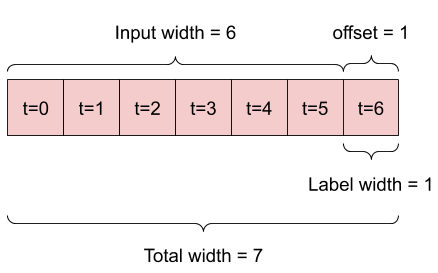

6시간의 기록이 주어졌을 때, 앞으로 1시간 뒤의 미래를 단일 예측하는 모델에 필요한 window

In [4]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
               label_columns=["T (degC)"])

w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column names(s): ['T (degC)']

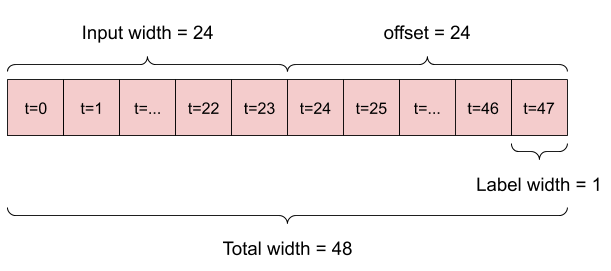

24시간의 기록이 주어졌을 때, 앞으로 24시간 뒤의 미래를 단일 예측하는 모델에 필요한 window

In [5]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
               label_columns=["T (degC)"])

w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column names(s): ['T (degC)']

w2 분할

In [6]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
        
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the 'tf.data.Datasets' are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [7]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


위의 코드는 3개의 7-timestep window 배치를 사용하며, 각 timestep에는 19개의 feature가 있습니다. 그러면 이것을 한 배치 당, 6-timestep과 19개의 input features 및 1-timestep 1-특성 레이블로 분할합니다.

레이블에는 하나의 특성만 있는데, 이는 WindowGenerator가 label_columns=["T (degC)"]로 초기화되었기 때문입니다. 우선 단일 출력 레이블을 예측하는 모델을 빌드해보자.

분할 window를 간단하게 시각화할 수 있는 plot 메서드:

In [8]:
w2.example = example_inputs, example_labels

In [9]:
plot_col = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

In [10]:
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize =(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label='Labels', c='#2ca02c', s=64)

        if model is not None:
            predicitions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                       marker='X', edgecolors='k', label='predictions',
                       c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [h]')
    
WindowGenerator.plot = plot

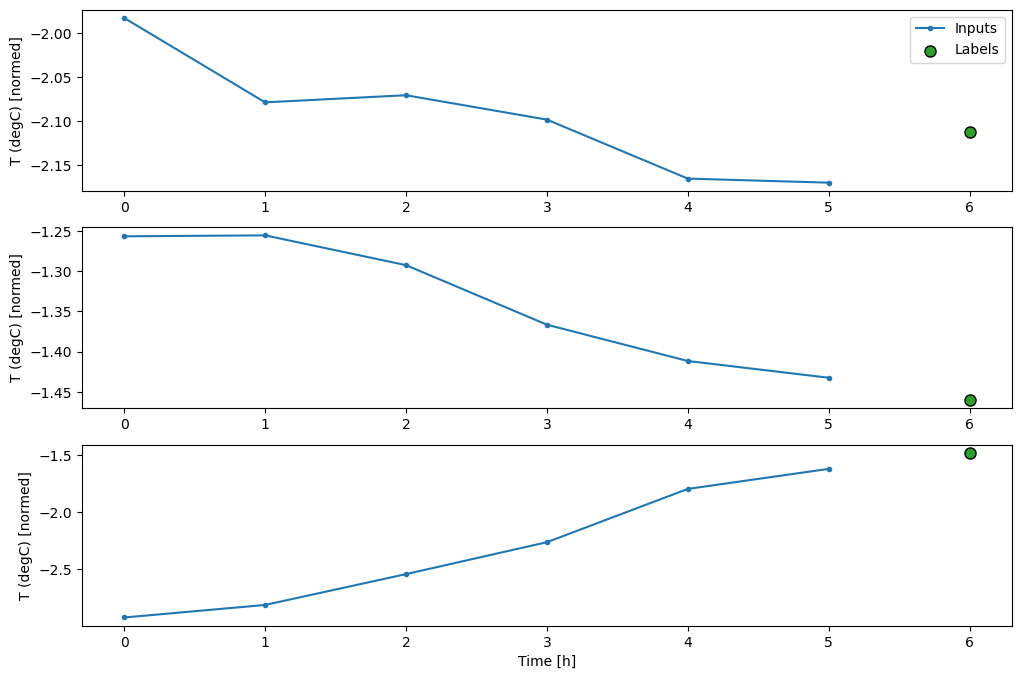

In [11]:
w2.plot()

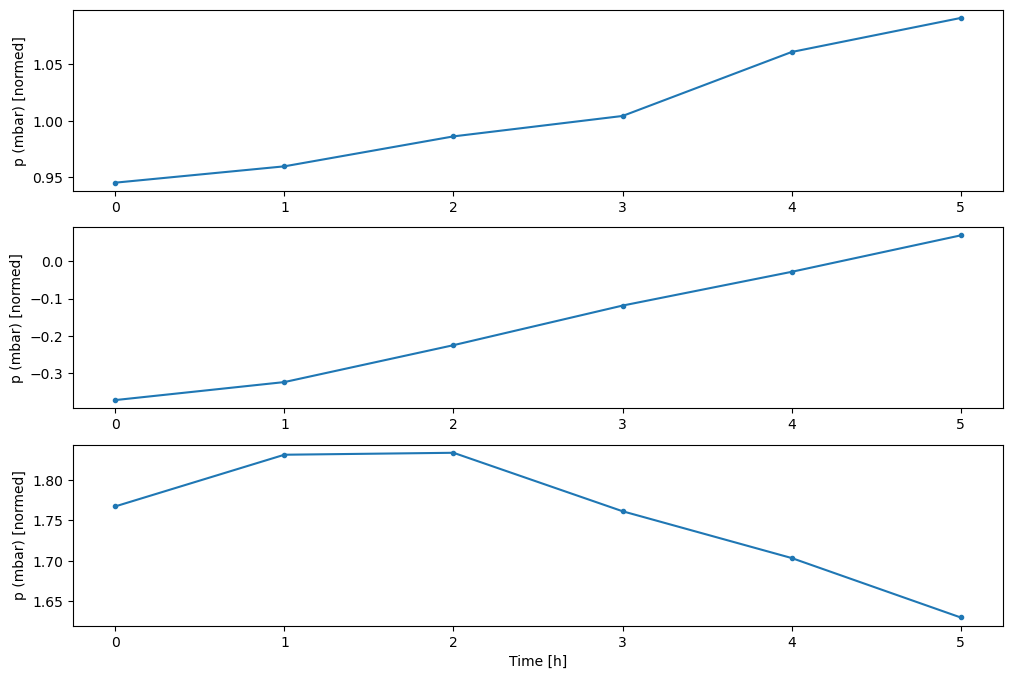

In [12]:
#다른 열을 plot할 수 있지만, w2 구성에는 T (degC)열에 대한 레이블만 있다.
w2.plot(plot_col='p (mbar)')

make_dataset 메서드는 시계열 DataFrame을 가져와, tf.keras.utils.timeseries_dataset_from_array 함수를 이용해 (input_window, label_window) 쌍의 tf.data.Dataset으로 변환한다.

In [13]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

make_dataset 메서드를 사용하여 tf.data.Dataset로 엑세스하기 위한 속성을 추가하자. 쉽게 엑세스하고 plotting할 수 있도록 표준 예제 batch를 추가하자:

In [14]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of
    'inputs, labels' for plotting.
    """
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found. so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test 
WindowGenerator.example = example

이제 WindowGenerator 객체가 tf.data.Dataset 객체에 대한 액세스 권한을 부여하므로, 데이터를 쉽게 반복할 수 있다. 

Dataset.element_spec 속성은 dataset 요소의 구조, 데이터 유형, 형상을 알려준다:

In [15]:
# Each element is a (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Dataset을 반복하면 구체적인 batch가 생성된다:

In [16]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


### single step model
이러한 종류의 데이터를 기반으로 빌브할 수 있는 가장 간단한 모델은, 현재 조건만을 기초로 1 timestep(이 시점에서의 data에서는 1시간) 후의 단일 특성 값을 예측하는 모델이다. 따라서 1시간 미래의 T (degC) 값을 예측하는 모델을 빌드해보자:

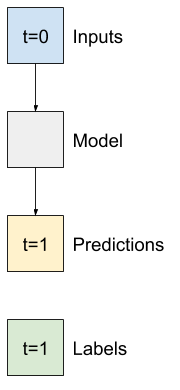

1시간 미래의 T (degC) 값을 예측하는 모델

다음과 같이 sigle step (input, label) pair를 생성하도록 WindowGenrator 객체를 구성해보자:

In [17]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
               label_columns=["T (degC)"])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column names(s): ['T (degC)']

winodw 객체는 train, valid, test 세트로부터 tf.data.DataSets를 생성하므로 데이터 batch를 쉽게 반복할 수 있다:

In [18]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### model1
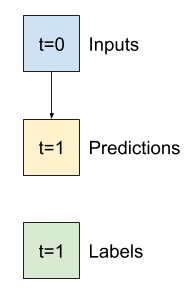
모든 특성의 현재 값을 고려하여 1시간 후의 온도를 예측
- 현재 값에는 현재 온도가 포함 됨
- 따라서 예측으로 현재 온도를 반환하여 "변화없음"을 예측하는 모델을 만들어보자.
- 온도는 천천히 변하기 때문에 이는 타당하다. 물론 더 미래로 들어갈 수록 이 기준의 예측 효과는 떨어질 것이다.


In [19]:
# 이게 모델이다!?
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is not None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

위 model을 인스턴스화하고 평가해보자:

In [20]:
baseline = Baseline(label_index=column_indices["T (degC)"])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
baseline.evaluate(single_step_window.test, verbose=0)

AttributeError: 'WindowGenerator' object has no attribute 'val_df'

In [ ]:
val_df